# Forest Cover Type Prediction

In [3]:
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# Features
* Elevation - Elevation in meters, 해발 고도
* Aspect - Aspect in degrees azimuth, 자침(나침반) 각도 [0-360]
* Slope - Slope in degrees, 경사 각도 [0-360]
<br><br>
* Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
* Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
<br><br>
* Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
* Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
<br><br>
* Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
* Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
* Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
<br><br>
* Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
* Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
<br><br>
* Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

In [5]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# Feature categorization
[Continuous]
* 'Elevation'
* 'Horizontal_Distance_To_Hydrology'
* 'Vertical_Distance_To_Hydrology'
* 'Horizontal_Distance_To_Roadways'
* 'Horizontal_Distance_To_Fire_Points'

<br>
[Categorical]
* 'Aspect', 'Slope'
  * [0-360] index
* 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'
  * [0-255] index
* Wilderness_{1-4}
  * 1 - Rawah Wilderness Area
  * 2 - Neota Wilderness Area
  * 3 - Comanche Peak Wilderness Area
  * 4 - Cache la Poudre Wilderness Area
* Soil_Type{1-40}

<br>
[Target feature]
* 'Cover_Type'
  * 1 - Spruce/Fir
  * 2 - Lodgepole Pine
  * 3 - Ponderosa Pine
  * 4 - Cottonwood/Willow
  * 5 - Aspen
  * 6 - Douglas-fir
  * 7 - Krummholz

In [7]:
major_features = ['Elevation', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',\
                         'Horizontal_Distance_To_Fire_Points', 'Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']

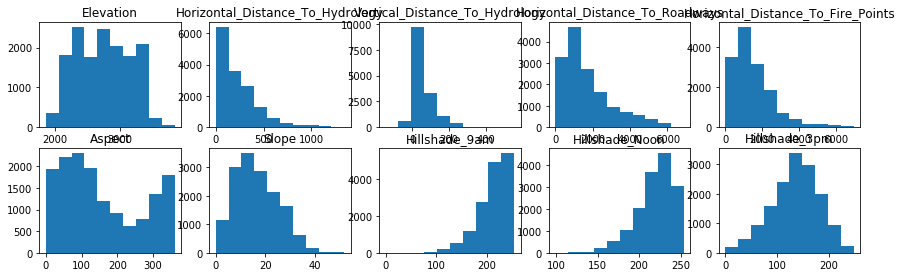

In [10]:
f, axarr = plt.subplots(2, 5)

for i, col in enumerate(major_features):
    
    if i < 5:
        axarr[0, i].hist(train_df[col])
        axarr[0, i].set_title(col)
        
    else:
        axarr[1, i-5].hist(train_df[col])
        axarr[1, i-5].set_title(col)

# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
#plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
#plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
#plt.figure(figsize=(100,100))
plt.subplots_adjust(left=0.1, right=2.0, top=0.9, bottom=0.1)
plt.show()

In [11]:
# 긱 CoverType에 대한 Elevation값의 최소/최대값
for covertype in range(1, 8):
    print(train_df[train_df.Cover_Type==covertype]['Elevation'].sort_values().iloc[0], \
          train_df[train_df.Cover_Type==covertype]['Elevation'].sort_values().iloc[-1])

2525 3675
2169 3413
1903 2850
1989 2526
2482 3007
1863 2883
2870 3849


In [12]:
# 긱 CoverType에 대한 Aspect값의 최소/최대값
for covertype in range(1, 8):
    print(train_df[train_df.Cover_Type==covertype]['Aspect'].sort_values().iloc[0], \
          train_df[train_df.Cover_Type==covertype]['Aspect'].sort_values().iloc[-1])

0 359
0 359
0 360
0 359
0 359
0 360
0 359


In [13]:
# 긱 CoverType에 대한 Slope값의 최소/최대값
for covertype in range(1, 8):
    print(train_df[train_df.Cover_Type==covertype]['Slope'].sort_values().iloc[0], \
          train_df[train_df.Cover_Type==covertype]['Slope'].sort_values().iloc[-1])

1 41
0 45
1 47
1 46
1 50
1 52
0 49


In [14]:
# 긱 CoverType에 대한 Hillshade Index 최소/최대값
for covertype in range(1, 8):
    print(train_df[train_df.Cover_Type==covertype]['Hillshade_9am'].sort_values().iloc[0], \
          train_df[train_df.Cover_Type==covertype]['Hillshade_9am'].sort_values().iloc[-1], \
         train_df[train_df.Cover_Type==covertype]['Hillshade_9am'].mean())

86 254 211.690277778
83 254 214.044444444
58 254 201.655555556
127 254 227.968055556
130 254 223.368981481
0 254 193.562962963
97 254 216.639814815


In [15]:
soils_covers = []

for cover in range(1, 8):
    soils_cover = []
    for soil_num in range(1, 41):
        
        soiltype_by_covertype = train_df[train_df.Cover_Type==cover]['Soil_Type'+str(soil_num)].sum()
        #print('Soil_Type'+str(soil_num), soiltype_by_covertype)
        soils_cover.append(soiltype_by_covertype)
    soils_covers.append(soils_cover)

In [16]:
soils_by_covertypes = []

for i, cover in enumerate(soils_covers):
    print(cover)
    
    soils_by_covertype = []
    for i, soilcover in enumerate(cover):
        if soilcover:
            soils_by_covertype.append(i+1)
            
    soils_by_covertypes.append(soils_by_covertype)

[0, 0, 0, 5, 0, 0, 0, 0, 1, 9, 5, 24, 17, 0, 0, 9, 2, 0, 15, 41, 12, 275, 376, 128, 0, 7, 7, 0, 407, 81, 114, 230, 184, 0, 3, 0, 0, 80, 79, 49]
[0, 3, 12, 20, 0, 7, 0, 1, 9, 81, 67, 203, 84, 0, 0, 14, 7, 16, 13, 55, 0, 54, 149, 72, 1, 19, 5, 6, 554, 144, 97, 255, 184, 12, 1, 2, 0, 7, 3, 3]
[121, 283, 133, 462, 55, 248, 0, 0, 0, 717, 89, 0, 4, 4, 0, 5, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0]
[139, 94, 799, 133, 39, 244, 0, 0, 0, 170, 24, 0, 0, 128, 0, 40, 350, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 61, 0, 129, 0, 0, 0, 0, 0, 64, 154, 0, 305, 0, 0, 9, 131, 44, 18, 6, 0, 0, 157, 11, 0, 28, 0, 3, 254, 480, 87, 100, 115, 4, 0, 0, 0, 0, 0, 0]
[95, 182, 18, 87, 71, 151, 0, 0, 0, 1101, 67, 0, 66, 37, 0, 37, 88, 0, 0, 37, 0, 0, 3, 15, 0, 0, 0, 0, 0, 0, 7, 30, 66, 2, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 16, 72, 31, 0, 0, 3, 0, 76, 20, 27, 70, 67, 4, 98, 8, 34, 641, 575, 407]


CoverType|SoilTypes|len(SoilTypes)
:---:|:---:|:---:
1|4, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32, 33, 35, 38, 39, 40|25
2|2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40|33
3|1, 2, 3, 4, 5, 6, 10, 11, 13, 14, 16, 17, 32|13
4|1, 2, 3, 4, 5, 6, 10, 11, 14, 16, 17|11
5|2, 4, 10, 11, 13, 16, 17, 18, 19, 20, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34|20
6|1, 2, 3, 4, 5, 6, 10, 11, 13, 14, 16, 17, 20, 23, 24, 31, 32, 33, 34|19
7|4, 21, 22, 23, 24, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40|18

In [17]:
sns.set_style("white")

In [18]:
def create_zero_column(length, name):
    return pd.DataFrame(np.zeros(length), columns=[name], dtype=int)

In [19]:
def create_dist_prob_columns_(Xdf, ydf, target, log=False):
    
    if log:
        Xdf[target+'_log'] = np.log(Xdf[target])
        #X_test[target+'_log'] = np.log(X_test[target])
    
    for i in ydf.unique():
        elev_cover_idx = (ydf==i)

        elev_cover_mean = Xdf[target+'_log'][elev_cover_idx].mean()
        elev_cover_std = Xdf[target+'_log'][elev_cover_idx].std()
        
        #Xdf[target+'_log_pdf_'+str(i)] = create_zero_column(Xdf.shape[0], target+'_log_pdf_'+str(i))
        #Xdf[target+'_log_cdf_'+str(i)] = create_zero_column(Xdf.shape[0], target+'_log_pdf_'+str(i))
        
        Xdf[target+'_log_pdf_'+str(i)] = norm.pdf(Xdf[target+'_log'],elev_cover_mean, elev_cover_std)
        Xdf[target+'_log_cdf_'+str(i)] = norm.cdf(Xdf[target+'_log'],elev_cover_mean, elev_cover_std)
        #X_test[target+'_log_pdf_'+str(i)] = norm.pdf(X_test[target+'_log'],elev_cover_mean, elev_cover_std)
        #X_test[target+'_log_cdf_'+str(i)] = norm.cdf(X_test[target+'_log'],elev_cover_mean, elev_cover_std)
        
        for j in Xdf['Wilderness_Area'].unique():
            
            elev_wild_cover_idx = ((ydf==i) & (X_test['Wilderness_Area']==j))

            elev_wild_cover_mean = Xdf[target+'_log'][elev_wild_cover_idx].mean()
            elev_wild_cover_std = Xdf[target+'_log'][elev_wild_cover_idx].std()
            
            #Xdf[target+'_log_wild_pdf_'+str(i)+str(j)] = create_zero_column(Xdf.shape[0], target+'_log_wild_pdf_'+str(i)+str(j))
            #Xdf[target+'_log_wild_cdf_'+str(i)+str(j)] = create_zero_column(Xdf.shape[0], target+'_log_wild_pdf_'+str(i)+str(j))
            
            Xdf[target+'_log_wild_pdf_'+str(i)+str(j)] = \
                                            norm.pdf(Xdf[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            Xdf[target+'_log_wild_cdf_'+str(i)+str(j)] = \
                                            norm.cdf(Xdf[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            #X_test[target+'_log_wild_pdf_'+str(i)+str(j)] = \
            #                                norm.pdf(X_test[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            #X_test[target+'_log_wild_cdf_'+str(i)+str(j)] = \
            #                                norm.cdf(X_test[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            
            
    Xdf.fillna(0, inplace=True)
    #X_test.fillna(0, inplace=True)



### Cover_Type (Target Feature, 7 classes)

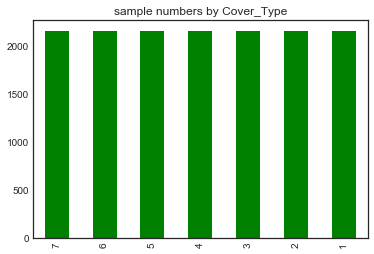

In [20]:
train_df.Cover_Type.value_counts().plot(kind='bar', color='g'); plt.title('sample numbers by Cover_Type'); plt.show()

In [21]:
con_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']

for cont in con_cols:
    
    #print(cont, len(train_df[cont][train_df[cont]==0]))
    #print(cont, len(test_df[cont][test_df[cont]==0]))
    
    #print(' - ')
    
    test_df[cont] += 0.3
    train_df[cont] += 0.3
    #print(cont, len(train_df[cont][train_df[cont]==0]))
    #print(cont, len(test_df[cont][test_df[cont]==0]))
    #print(' # ')

In [22]:
train_df['Wilderness_Area'] = create_zero_column(train_df.shape[0], 'Wilderness_Area')
for i in range(1, 5):
    wilderness = 'Wilderness_Area'+str(i)
    train_df['Wilderness_Area'][train_df[wilderness]==1] += i

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# Slope

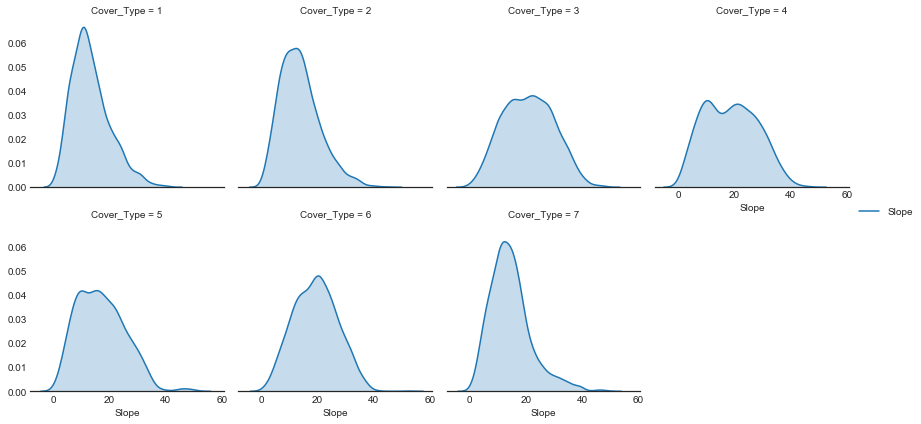

In [23]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, col_wrap=4)
g.map(sns.kdeplot, "Slope", shade=True).add_legend()
sns.despine(left=True)
plt.show()

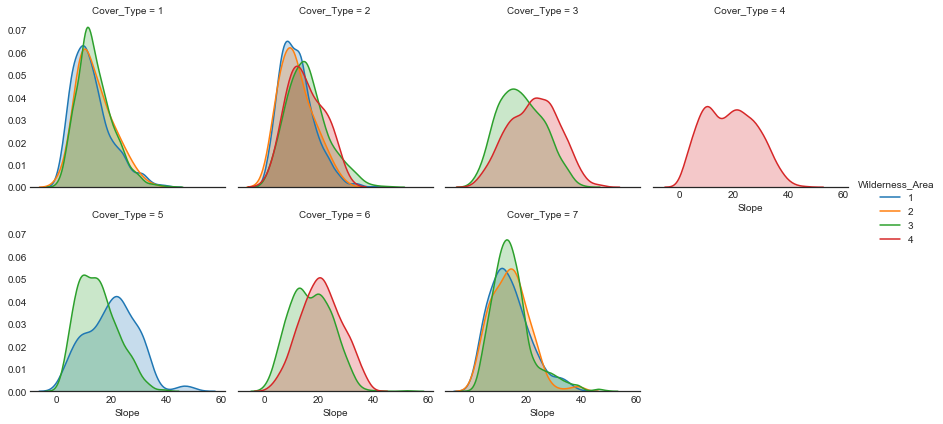

In [24]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Slope", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [25]:
train_df['Slope_log'] = np.log(train_df['Slope'])

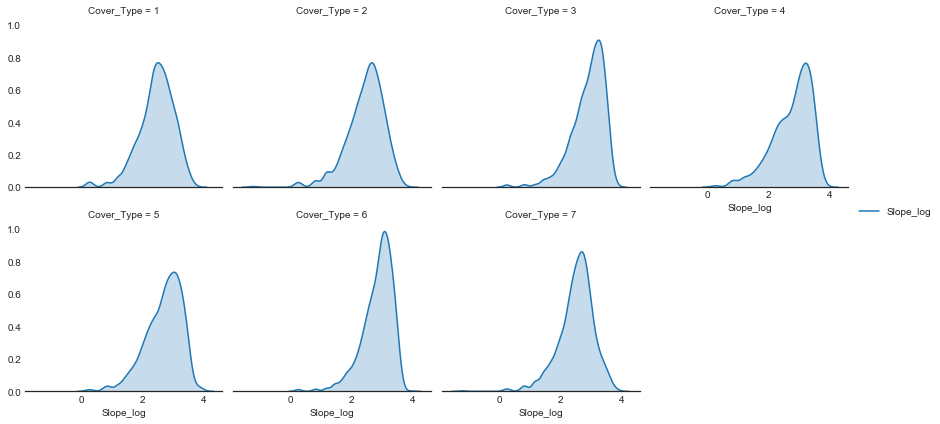

In [26]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, col_wrap=4)
g.map(sns.kdeplot, "Slope_log", shade=True).add_legend()
sns.despine(left=True)
plt.show()

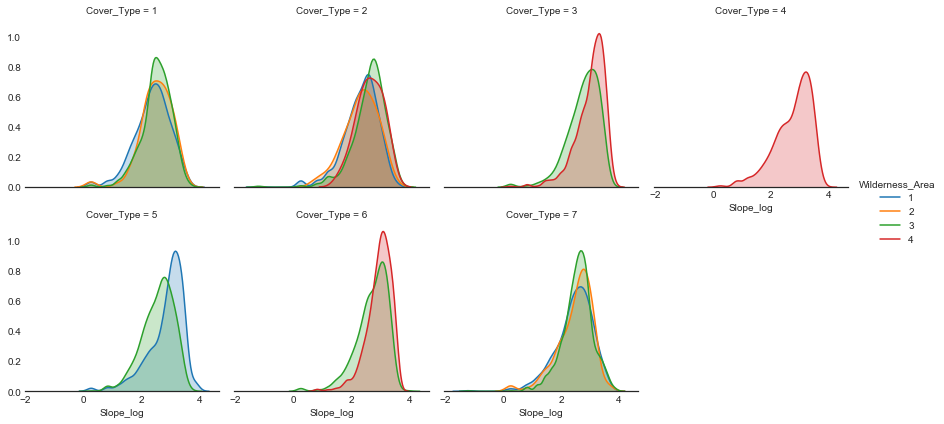

In [27]:
g = sns.FacetGrid(train_df, col="Cover_Type", hue='Wilderness_Area', size=3, col_wrap=4)
g.map(sns.kdeplot, "Slope_log", shade=True).add_legend()
sns.despine(left=True)
plt.show()

# Elevation

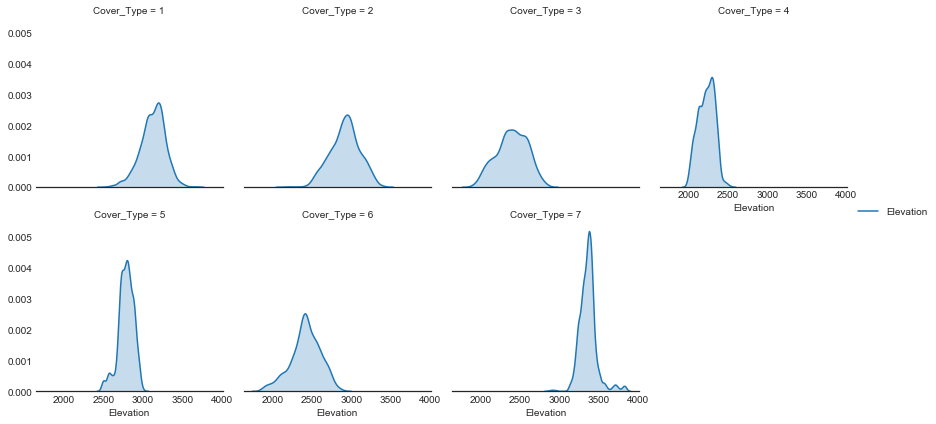

In [28]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, col_wrap=4)
g.map(sns.kdeplot, "Elevation", shade=True).add_legend()
sns.despine(left=True)
plt.show()

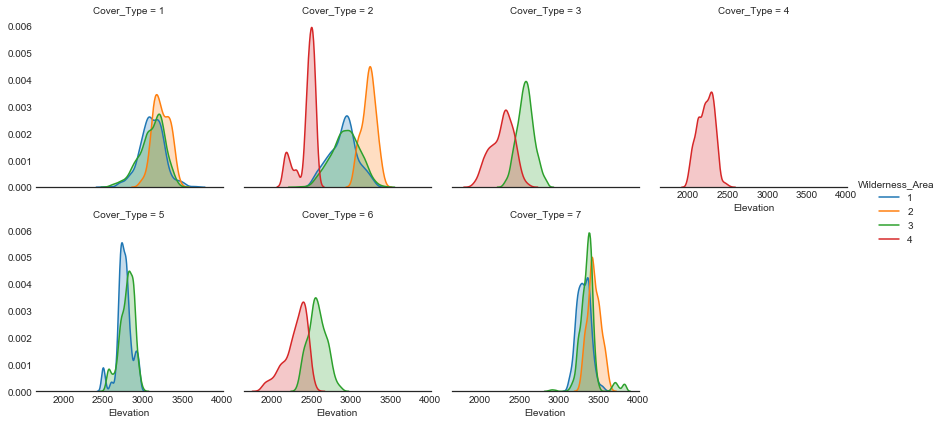

In [29]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area',col_wrap=4)
g.map(sns.kdeplot, "Elevation", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [30]:
train_df['Elevation_log'] = np.log(train_df['Elevation'])

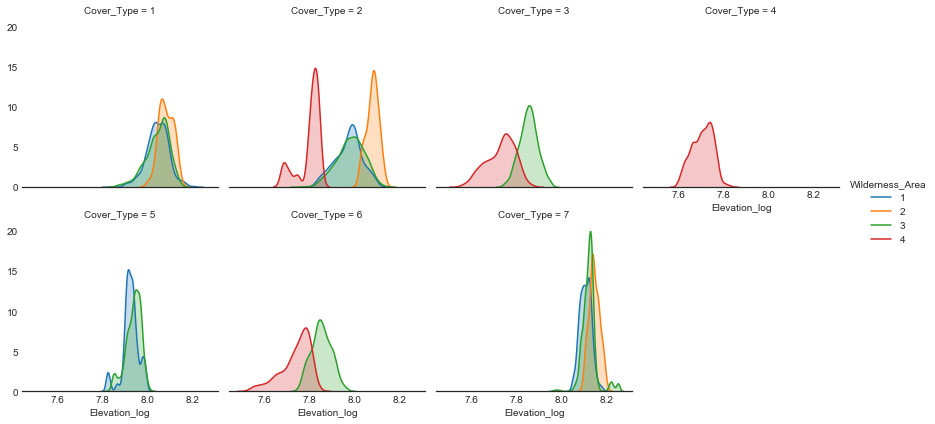

In [31]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area',col_wrap=4)
g.map(sns.kdeplot, "Elevation_log", shade=True).add_legend()
sns.despine(left=True)
plt.show()

## Aspect

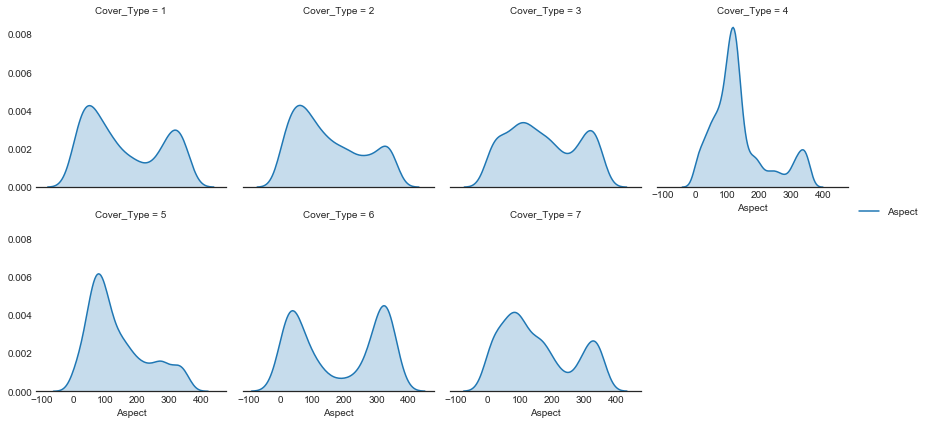

In [32]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, col_wrap=4)
g.map(sns.kdeplot, "Aspect", shade=True).add_legend()
sns.despine(left=True)
plt.show()

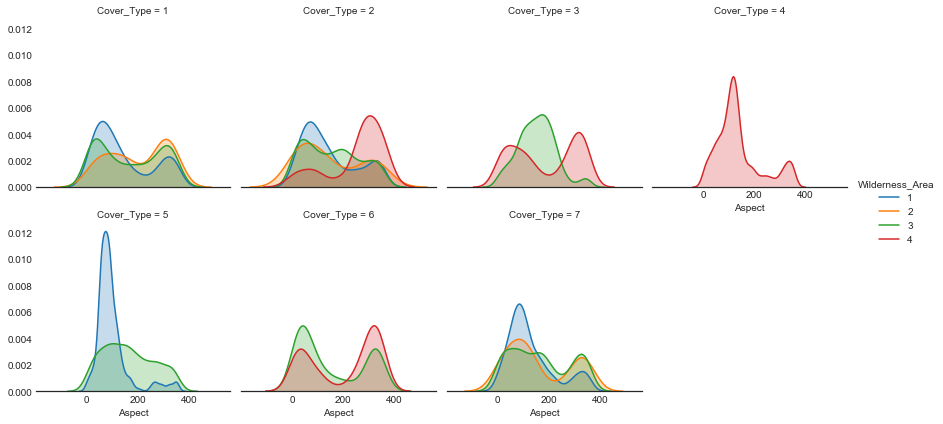

In [33]:
g = sns.FacetGrid(train_df, col="Cover_Type",hue='Wilderness_Area', size=3, col_wrap=4)
g.map(sns.kdeplot, "Aspect", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [34]:
train_df['Aspect_log'] = np.log(train_df['Aspect'])

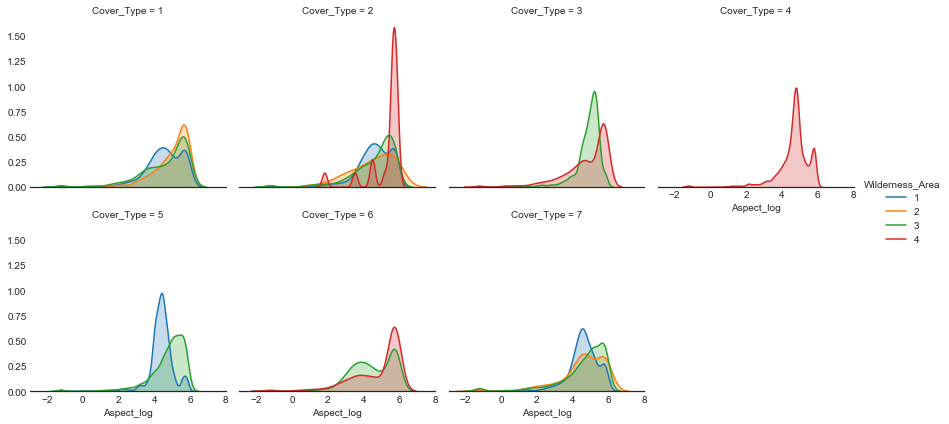

In [35]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3,hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Aspect_log", shade=True).add_legend()
sns.despine(left=True)
plt.show()

# Feature engineering
Focus on engineering distance continuous feature

In [36]:
X = train_df.drop(['Cover_Type'], axis=1)
X['dataset'] = 0

In [37]:
X_t = test_df
X_t['dataset'] = 1

In [38]:
y_train = train_df.Cover_Type

In [39]:
def create_dist_prob_columns_(Xdf, ydf, X_, target):
    
    Xdf[target+'_log'] = np.log(Xdf[target])
    X_[target+'_log'] = np.log(X_[target])
    
    for i in ydf.unique():
        elev_cover_idx = (ydf==i)

        elev_cover_mean = Xdf[target+'_log'][elev_cover_idx].mean()
        elev_cover_std = Xdf[target+'_log'][elev_cover_idx].std()
        
        #Xdf[target+'_log_pdf_'+str(i)] = create_zero_column(Xdf.shape[0], target+'_log_pdf_'+str(i))
        #Xdf[target+'_log_cdf_'+str(i)] = create_zero_column(Xdf.shape[0], target+'_log_pdf_'+str(i))
        
        Xdf[target+'_log_pdf_'+str(i)] = norm.pdf(Xdf[target+'_log'],elev_cover_mean, elev_cover_std)
        Xdf[target+'_log_cdf_'+str(i)] = norm.cdf(Xdf[target+'_log'],elev_cover_mean, elev_cover_std)
        X_[target+'_log_pdf_'+str(i)] = norm.pdf(X_[target+'_log'],elev_cover_mean, elev_cover_std)
        X_[target+'_log_cdf_'+str(i)] = norm.cdf(X_[target+'_log'],elev_cover_mean, elev_cover_std)
        
        for j in Xdf['Wilderness_Area'].unique():
            
            elev_wild_cover_idx = ((ydf==i) & (X_['Wilderness_Area']==j))

            elev_wild_cover_mean = Xdf[target+'_log'][elev_wild_cover_idx].mean()
            elev_wild_cover_std = Xdf[target+'_log'][elev_wild_cover_idx].std()
            
            #Xdf[target+'_log_wild_pdf_'+str(i)+str(j)] = create_zero_column(Xdf.shape[0], target+'_log_wild_pdf_'+str(i)+str(j))
            #Xdf[target+'_log_wild_cdf_'+str(i)+str(j)] = create_zero_column(Xdf.shape[0], target+'_log_wild_pdf_'+str(i)+str(j))
            
            Xdf[target+'_log_wild_pdf_'+str(i)+str(j)] = \
                                            norm.pdf(Xdf[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            Xdf[target+'_log_wild_cdf_'+str(i)+str(j)] = \
                                            norm.cdf(Xdf[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            X_[target+'_log_wild_pdf_'+str(i)+str(j)] = \
                                            norm.pdf(X_[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            X_[target+'_log_wild_cdf_'+str(i)+str(j)] = \
                                            norm.cdf(X_[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            
            
    Xdf.fillna(0, inplace=True)
    X_.fillna(0, inplace=True)



In [40]:
X['Wilderness_Area'] = create_zero_column(X.shape[0], 'Wilderness_Area')
X_t['Wilderness_Area'] = create_zero_column(X_t.shape[0], 'Wilderness_Area')
for i in range(1, 5):
    wilderness = 'Wilderness_Area'+str(i)
    X['Wilderness_Area'][X[wilderness]==1] += i
    X_t['Wilderness_Area'][X_t[wilderness]==1] += i

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [41]:
create_dist_prob_columns_(X, y_train, X_t, 'Slope')
create_dist_prob_columns_(X, y_train, X_t, 'Elevation')
create_dist_prob_columns_(X, y_train, X_t,'Aspect')

/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


In [42]:
X = pd.concat([X, X_t], axis=0)

In [43]:
X.shape

(581012, 270)

### Meaning of 'Aspect'
The compass direction that the slope faces is your slope aspect.
![](http://gisgeography.com/wp-content/uploads/2016/06/Aspect-Legend.png)

**북쪽으로부터**|
:---:|:---:|:---:|:---:
북|0°or 360°|남|180°
북-북동|22.5°|남-남서|202.5°
북동|45°|남서|225°
동-북동|67.5°|서-남서|247.5°
동|90°|서|270°
동-남동|112.5°|서-북서|292.5°
남동|135°|북서|315°
남-남동|157.5°|북-북서|337.5°

In [44]:
# reflecting supportive adding scalar to aspect_step
def aspect_map2(x):
    # north = 1, northeast = 2, east = 3, southeast = 4, south = 5, southwest = 6, west = 7, northwest = 8
    
    aspect_step = 22.5
    start = aspect_step/2 + 0.3
    
    if (0.3 <= x < start) or (360.3 - aspect_step/2 <= x <= 360.3): return 1;
    elif (start <= x < start+aspect_step): return 2;
    elif (start+aspect_step <= x < start+aspect_step*2): return 3;
    elif (start+aspect_step*2 <= x < start+aspect_step*3): return 4;
    elif (start+aspect_step*3 <= x < start+aspect_step*4): return 5;
    elif (start+aspect_step*4 <= x < start+aspect_step*5): return 6;
    elif (start+aspect_step*5 <= x < start+aspect_step*6): return 7;
    elif (start+aspect_step*6 <= x < start+aspect_step*7): return 8;
    elif (start+aspect_step*7 <= x < start+aspect_step*8): return 9;
    elif (start+aspect_step*8 <= x < start+aspect_step*9): return 10;
    elif (start+aspect_step*9 <= x < start+aspect_step*10): return 11;
    elif (start+aspect_step*10 <= x < start+aspect_step*11): return 12;
    elif (start+aspect_step*11 <= x < start+aspect_step*12): return 13;
    elif (start+aspect_step*12 <= x < start+aspect_step*13): return 14;
    elif (start+aspect_step*13 <= x < start+aspect_step*14): return 15;
    elif (start+aspect_step*14 <= x < start+aspect_step*15): return 16;



In [45]:
def aspect_map(x):
    # north = 1, northeast = 2, east = 3, southeast = 4, south = 5, southwest = 6, west = 7, northwest = 8
    
    if (0+0.3 <= x < 22.5+0.3) or (337.5+0.3 <= x <= 360+0.3): return 1;
    elif (22.5+0.3 <= x < 67.5+0.3): return 2;
    elif (67.5+0.3 <= x < 112.5+0.3): return 3;
    elif (112.5+0.3 <= x < 157.5+0.3): return 4;
    elif (157.5+0.3 <= x < 202.5+0.3): return 5;
    elif (202.5+0.3 <= x < 247.5+0.3): return 6;
    elif (247.5+0.3 <= x < 292.5+0.3): return 7;
    else: return 8;

In [46]:
X['Slope_Direction'] = X['Aspect'].apply(aspect_map)

In [47]:
# slope direction into dummies
X = pd.concat([X, pd.get_dummies(X.Slope_Direction, prefix='Slope_Direction')], axis=1)

In [48]:
X['Slope_Direction2'] = X['Aspect'].apply(aspect_map2)

In [49]:
# slope direction into dummies
X = pd.concat([X, pd.get_dummies(X.Slope_Direction2, prefix='Slope_Direction2')], axis=1)

# Feature Boundary by Cover Type
* Elevation
  * Elevation_Cover{1-7}
* Slope
  * Slope_Cover{1-7}
* Asepct
  * Aspect_Cover{1-7}
* Hillshade_9am
  * Hillshade_9am_Cover{1-7}
* Hillshade_Noon
  * Hillshade_Noon_Cover{1-7}
* Hillshade_3pm
  * Hillshade_3pm_Cover{1-7}

CoverType|SoilTypes|len(SoilTypes)
:---:|:---:|:---:
1|4, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32, 33, 35, 38, 39, 40|25
2|2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40|33
3|1, 2, 3, 4, 5, 6, 10, 11, 13, 14, 16, 17, 32|13
4|1, 2, 3, 4, 5, 6, 10, 11, 14, 16, 17|11
5|2, 4, 10, 11, 13, 16, 17, 18, 19, 20, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34|20
6|1, 2, 3, 4, 5, 6, 10, 11, 13, 14, 16, 17, 20, 23, 24, 31, 32, 33, 34|19
7|4, 21, 22, 23, 24, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40|18

In [50]:
X['Soil_Type'] = create_zero_column(X.shape[0], 'Soil_Type')
for i in range(1, 41):
    wilderness = 'Soil_Type'+str(i)
    X['Soil_Type'][X[wilderness]==1] += i

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [ ]:
for i in range(1, 8):
    X['Soils_Cover'+str(i)] = np.zeros(X.shape[0])

In [ ]:
for i, soils in enumerate(soils_by_covertypes):
    
    for j, soil in enumerate(soils):
    
        X['Soils_Cover'+str(i+1)][X['Soil_Type'] == soil] = 1
        

In [ ]:
for i in range(1, 8):
    X['Elevation_Cover'+str(i)] = np.zeros(X.shape[0])

In [ ]:
X['Elevation_Cover1'][(X.Elevation >= 2525) & (X.Elevation <= 3675)] = 1
X['Elevation_Cover2'][(X.Elevation >= 2169) & (X.Elevation <= 3413)] = 1
X['Elevation_Cover3'][(X.Elevation >= 1903) & (X.Elevation <= 2850)] = 1
X['Elevation_Cover4'][(X.Elevation >= 1989) & (X.Elevation <= 2526)] = 1
X['Elevation_Cover5'][(X.Elevation >= 2482) & (X.Elevation <= 3007)] = 1
X['Elevation_Cover6'][(X.Elevation >= 1863) & (X.Elevation <= 2883)] = 1
X['Elevation_Cover7'][(X.Elevation >= 2870) & (X.Elevation <= 3849)] = 1

In [ ]:
for i in range(1, 8):
    X['Slope_Cover'+str(i)] = np.zeros(X.shape[0])

X['Slope_Cover1'][(X.Slope >= 1) & (X.Slope <= 41)] = 1
X['Slope_Cover2'][(X.Slope >= 0) & (X.Slope <= 45)] = 1
X['Slope_Cover3'][(X.Slope >= 1) & (X.Slope <= 47)] = 1
X['Slope_Cover4'][(X.Slope >= 1) & (X.Slope <= 46)] = 1
X['Slope_Cover5'][(X.Slope >= 1) & (X.Slope <= 50)] = 1
X['Slope_Cover6'][(X.Slope >= 1) & (X.Slope <= 52)] = 1
X['Slope_Cover7'][(X.Slope >= 0) & (X.Slope <= 49)] = 1

In [ ]:
for i in range(1, 8):
    X['Hillshade_9am_Cover'+str(i)] = np.zeros(X.shape[0])

X['Hillshade_9am_Cover1'][(X.Hillshade_9am >= 86) & (X.Hillshade_9am <= 254)] = 1
X['Hillshade_9am_Cover2'][(X.Hillshade_9am >= 83) & (X.Hillshade_9am <= 254)] = 1
X['Hillshade_9am_Cover3'][(X.Hillshade_9am >= 58) & (X.Hillshade_9am <= 254)] = 1
X['Hillshade_9am_Cover4'][(X.Hillshade_9am >= 127) & (X.Hillshade_9am <= 254)] = 1
X['Hillshade_9am_Cover5'][(X.Hillshade_9am >= 130) & (X.Hillshade_9am <= 254)] = 1
X['Hillshade_9am_Cover6'][(X.Hillshade_9am >= 0) & (X.Hillshade_9am <= 254)] = 1
X['Hillshade_9am_Cover7'][(X.Hillshade_9am >= 97) & (X.Hillshade_9am <= 254)] = 1

In [ ]:
for i in range(1, 8):
    X['Hillshade_Noon_Cover'+str(i)] = np.zeros(X.shape[0])

X['Hillshade_Noon_Cover1'][(X.Hillshade_Noon >= 125) & (X.Hillshade_Noon <= 254)] = 1
X['Hillshade_Noon_Cover2'][(X.Hillshade_Noon >= 115) & (X.Hillshade_Noon <= 254)] = 1
X['Hillshade_Noon_Cover3'][(X.Hillshade_Noon >= 120) & (X.Hillshade_Noon <= 254)] = 1
X['Hillshade_Noon_Cover4'][(X.Hillshade_Noon >= 137) & (X.Hillshade_Noon <= 254)] = 1
X['Hillshade_Noon_Cover5'][(X.Hillshade_Noon >= 99) & (X.Hillshade_Noon <= 254)] = 1
X['Hillshade_Noon_Cover6'][(X.Hillshade_Noon >= 127) & (X.Hillshade_Noon <= 254)] = 1
X['Hillshade_Noon_Cover7'][(X.Hillshade_Noon >= 99) & (X.Hillshade_Noon <= 254)] = 1

In [ ]:
for i in range(1, 8):
    X['Hillshade_3pm_Cover'+str(i)] = np.zeros(X.shape[0])

X['Hillshade_3pm_Cover1'][(X.Hillshade_3pm >= 0) & (X.Hillshade_3pm <= 246)] = 1
X['Hillshade_3pm_Cover2'][(X.Hillshade_3pm >= 6) & (X.Hillshade_3pm <= 248)] = 1
X['Hillshade_3pm_Cover3'][(X.Hillshade_3pm >= 0) & (X.Hillshade_3pm <= 248)] = 1
X['Hillshade_3pm_Cover4'][(X.Hillshade_3pm >= 0) & (X.Hillshade_3pm <= 230)] = 1
X['Hillshade_3pm_Cover5'][(X.Hillshade_3pm >= 0) & (X.Hillshade_3pm <= 229)] = 1
X['Hillshade_3pm_Cover6'][(X.Hillshade_3pm >= 22) & (X.Hillshade_3pm <= 238)] = 1
X['Hillshade_3pm_Cover7'][(X.Hillshade_3pm >= 0) & (X.Hillshade_3pm <= 226)] = 1

In [ ]:
X['Elevation_SQRD'] = X['Elevation']**2
X['Elevation_CUBE'] = X['Elevation']**3
X['Slope_SQRD'] = X['Slope']**2
X['Slope_CUBE'] = X['Slope']**3
X['Aspect_SQRD'] = X['Aspect']**2
X['Aspect_CUBE'] = X['Aspect']**3

In [ ]:
X['Horizontal_Distance_To_Hydrology_SQRD'] = \
                    X['Horizontal_Distance_To_Hydrology']**2
X['Horizontal_Distance_To_Hydrology_CUBE'] = \
                    X['Horizontal_Distance_To_Hydrology']**3
X['Horizontal_Distance_To_Roadways_SQRD'] = \
                    X['Horizontal_Distance_To_Roadways']**2
X['Horizontal_Distance_To_Roadways_CUBE'] = \
                    X['Horizontal_Distance_To_Roadways']**3
X['Horizontal_Distance_To_Fire_Points_SQRD'] =\
                    X['Horizontal_Distance_To_Fire_Points']**2
X['Horizontal_Distance_To_Fire_Points_CUBE'] =\
                    X['Horizontal_Distance_To_Fire_Points']**3
X['Vertical_Distance_To_Hydrology_SQRD'] = \
                    X['Vertical_Distance_To_Hydrology']**2
X['Vertical_Distance_To_Hydrology_CUBE'] = \
                    X['Vertical_Distance_To_Hydrology']**3